In [9]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import time
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5.0, 10.0) 
print("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.2.0-dev 


In [11]:
filename = r'./testImages/1000967244029_3007_1.jpg'
assert os.path.isfile(filename), 'file does not exist!'

In [3]:
image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
print(gray.shape)

h, w = gray.shape

(1801, 1240, 3)
(1801, 1240)


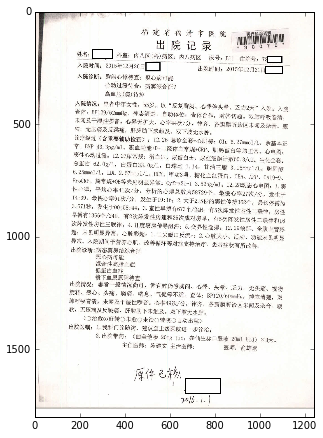

In [4]:
plt.imshow(image)

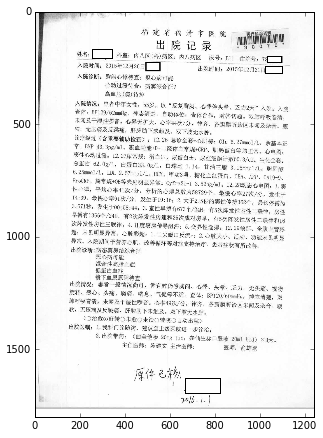

In [5]:
plt.imshow(gray, cmap='gray')

In [6]:
def rotate(image, angle, scale=1.0):
    h, w = image.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    # fill in 255 (white) as border during rotation
    rotated = cv2.warpAffine(image, M, (w, h), borderValue=255)
    return rotated

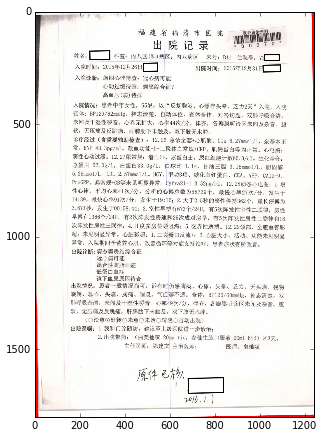

In [7]:
plt.imshow(rotate(image, 1), cmap='gray')

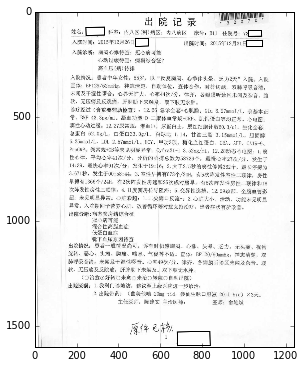

In [8]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0) 
plt.imshow(rotate(gray, 1)[100:-100, :], cmap='gray')

In [9]:
angles = []
max_vals = []
for angle in np.arange(-1., -1.9, 0.2):
    angle =0
    hproj = np.sum(rotate(image, angle), axis=1)
    vproj = np.sum(rotate(image, angle), axis=0)

    matplotlib.rcParams['figure.figsize'] = (5.0, 3.0) 
    plt.plot(hproj)
#     time.sleep(1)
    max_val = np.max(hproj)
    
    max_vals.append(max_val)
    angles.append(angle)
#     print('Angle {:.2f}, Max value {}'.format(angle, max_val))
    


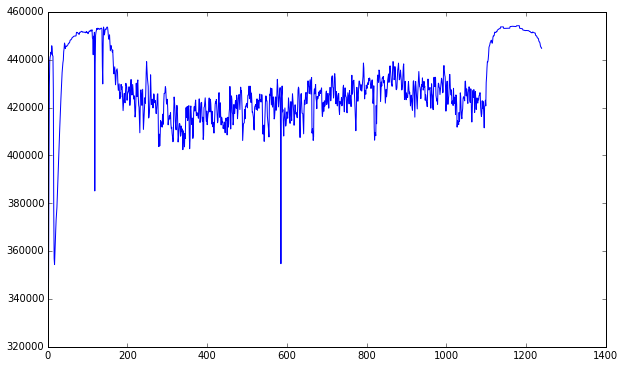

In [10]:
plt.plot(np.sum(rotate(gray, 0), axis=0))

In [11]:
hproj = np.sum(rotate(gray, 2), axis=1)
diff = np.diff(hproj.astype(np.int64))


In [12]:
hproj.shape

(1801,)

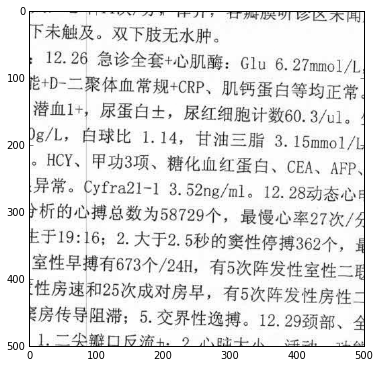

In [13]:
roi = gray[500:1000, 500:1000]
plt.imshow(roi, cmap='gray')

(array([   1326.,    2906.,    5470.,    6855.,    6362.,    5279.,
           5743.,    6816.,   11876.,  197367.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

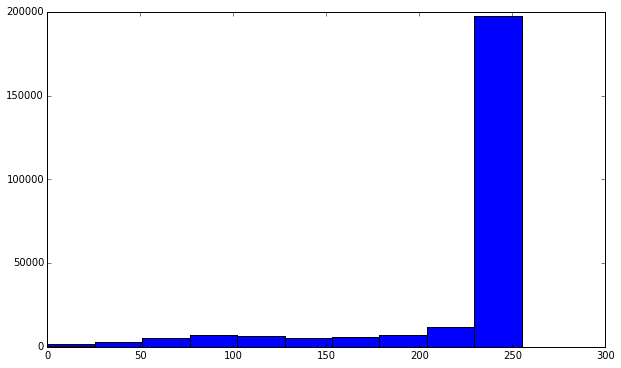

In [14]:
plt.hist(roi.flatten(), bins=10)

In [15]:
# if pixel > 200, then map to 255 (white); otherwise map to 0
(T, thresh) = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY)

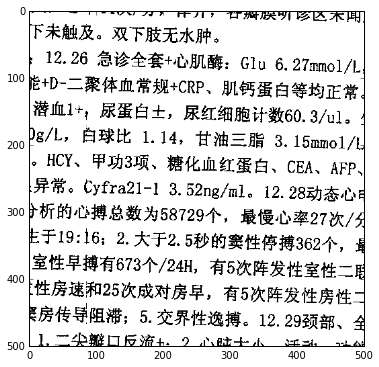

In [16]:
plt.imshow(thresh, cmap='gray')

(array([  39846.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  210154.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

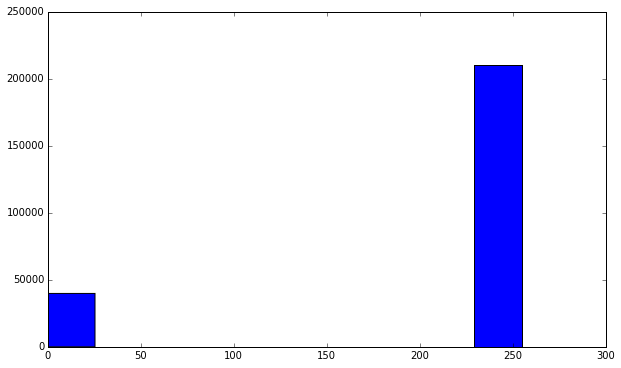

In [17]:
plt.hist(thresh.flatten(), bins=10)

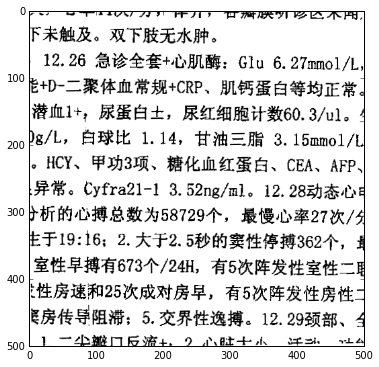

In [18]:
rotated = rotate(thresh, 1)
plt.imshow(rotated, cmap='gray')

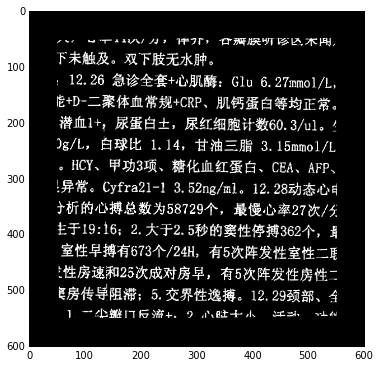

In [19]:
padded = np.ones((600, 600)) * 255
padded[50:550, 50:550] = rotated

# inversion
padded = 255 - padded
plt.imshow(padded, cmap='gray')

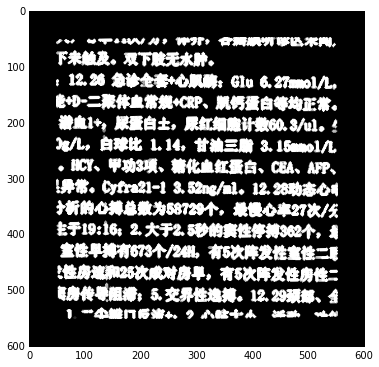

In [20]:
struct_elem = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
dilated = cv2.dilate(padded.copy(), struct_elem, iterations=2)
plt.imshow(dilated, cmap='gray')

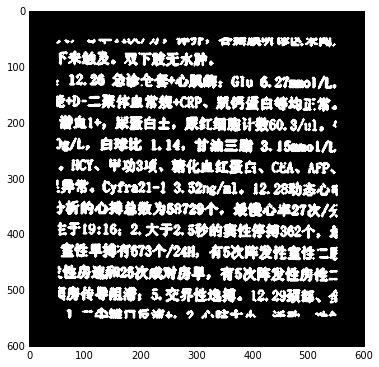

In [21]:
(T, thresh2) = cv2.threshold(dilated, 200, 255, cv2.THRESH_BINARY)
plt.imshow(thresh2, cmap='gray')

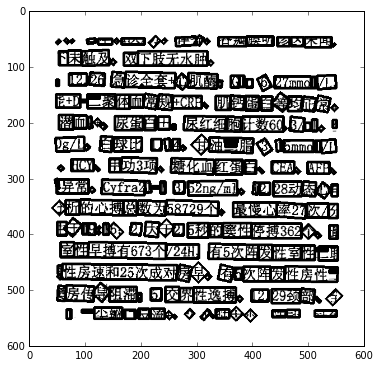

In [22]:
# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
im2, cnts, hierarchy = cv2.findContours(thresh2.copy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


c = sorted(cnts, key = cv2.contourArea, reverse = True)

# compute the rotated bounding box of the largest contour
for i in range(len(c)):
    rect = cv2.minAreaRect(c[i])
    box = np.int0(cv2.boxPoints(rect))
 
    # draw a bounding box arounded the detected barcode and display the
    # image
    cv2.drawContours(padded, [box], -1, 255, 3)
plt.imshow(255-padded, cmap='gray')

## Change to MORPH_RECT, dilate horizontal direction more as we would like to get short and wide bounding boxes

In [23]:


def find_bounding_box2(image, morph_size, iterations, threshold=128, roi_range=[], padding=0, ):
    if roi_range:
        # crop region of interest
        roi = image[roi_range[0]:roi_range[1], roi_range[2]:roi_range[3]]
    else:
        roi = image

    if padding:
        # create artificial white (255) boundary
        h, w = roi.shape[:2]
        padded = np.ones((h+100, w+100)) * 255
        padded[50:(50+h), 50:(50+w)] = roi
    else:
        padded = roi
    
    # thresholding 
    (T, thresh) = cv2.threshold(padded, threshold, 255, cv2.THRESH_BINARY)

    # rotation: relatively insensitive. Rotation angle can vary from -7 to 7 degrees
    rotated = rotate(thresh, 1)


    # inversion
    rotated = 255 - rotated
    print(rotated.shape)
        
    # un-isotropic structural element, blur more in x-direction
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    dilated = cv2.dilate(rotated.copy(), struct_elem, iterations=iterations)

    # thresholding
    (T, thresh2) = cv2.threshold(dilated, 200, 255, cv2.THRESH_BINARY)

    # find the contours in the thresholded image
    im2, cnts, hierarchy = cv2.findContours(thresh2.copy().astype(np.uint8), 
                                            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # sort the contours by their area, keeping only the largest one
    # c = sorted(cnts, key = cv2.contourArea, reverse = True)
    c = cnts

    # compute the rotated bounding box of the largest contour
    for i in range(len(c)):
        # find mininum bounding rectangular box
        rect = cv2.minAreaRect(c[i])
        box = np.int0(cv2.boxPoints(rect))
#         print(box)
        # draw a bounding box 
        cv2.drawContours(255-padded, [box], -1, 255, 2)
        
    return 255-padded, c
    



In [24]:


def find_bounding_box(image, morph_size, iterations, threshold=128, roi_range=[], padding=0, ):
    if roi_range:
        # crop region of interest
        roi = image[roi_range[0]:roi_range[1], roi_range[2]:roi_range[3]]
    else:
        roi = image

    print(roi.shape)
    
    # thresholding 
    (T, thresh) = cv2.threshold(roi, threshold, 255, cv2.THRESH_BINARY)

    # rotation: relatively insensitive. Rotation angle can vary from -7 to 7 degrees
    rotated = rotate(thresh, 1)

    if padding:
        # create artificial white (255) boundary
        h, w = rotated.shape[:2]
        padded = np.ones((h+100, w+100)) * 255
        padded[50:(50+h), 50:(50+w)] = rotated
    else:
        padded = rotated

    # inversion
    padded = 255 - padded
    print(padded.shape)
        
    # un-isotropic structural element, blur more in x-direction
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    dilated = cv2.dilate(padded.copy(), struct_elem, iterations=iterations)

    # thresholding
    (T, thresh2) = cv2.threshold(dilated, 200, 255, cv2.THRESH_BINARY)

    # find the contours in the thresholded image
    im2, cnts, hierarchy = cv2.findContours(thresh2.copy().astype(np.uint8), 
                                            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) > 100 ]
    
    # sort the contours by their area, keeping only the largest one
    # c = sorted(cnts, key = cv2.contourArea, reverse = True)
    c = cnts

    boxes = []
    # compute the rotated bounding box of the largest contour
    for i in range(len(c)):
        # find mininum bounding rectangular box
        rect = cv2.minAreaRect(c[i])
        box = np.int0(cv2.boxPoints(rect))
        boxes.append(box)
        # draw a bounding box 
        cv2.drawContours(padded, [box], -1, 255, 2)
        
    return padded, cnts, boxes
    



In [25]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped

(1801, 1240)
(1801, 1240)
[[1113 1519]
 [ 143 1506]
 [ 162   60]
 [1132   74]]


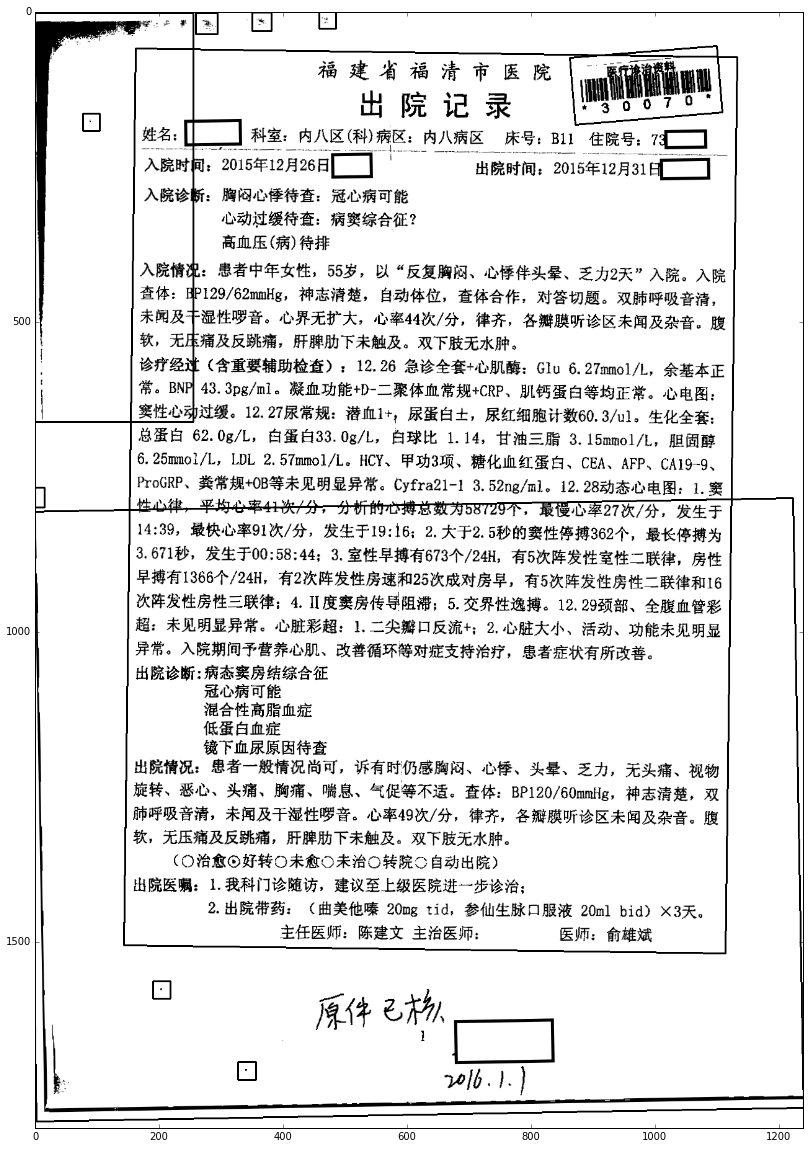

In [26]:
gray_boxed, cnts, boxes = find_bounding_box(gray, (10, 10), 3, threshold=200, padding=0)
matplotlib.rcParams['figure.figsize'] = (40.0, 20.0) 
plt.imshow(255 - gray_boxed, cmap='gray')

cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
rect = cv2.minAreaRect(cnts_sorted[0]) # get the largest bounding box
max_box = np.int0(cv2.boxPoints(rect))
print(max_box)

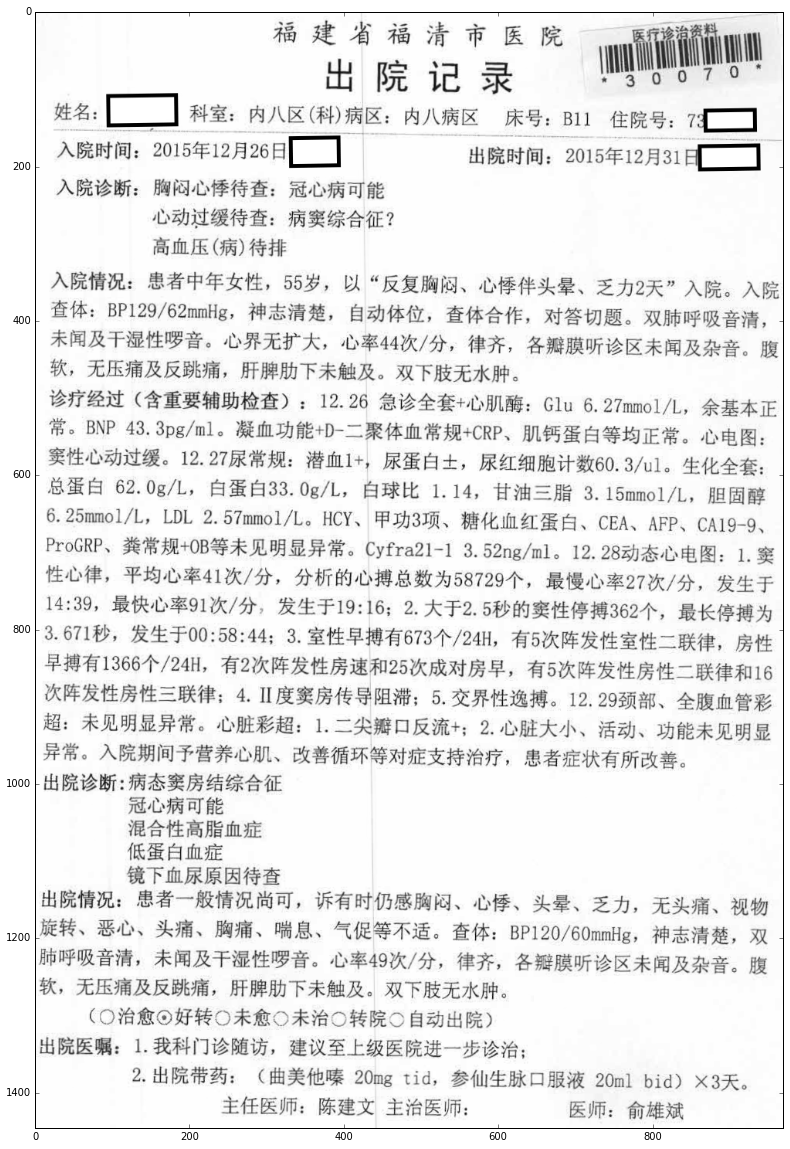

In [33]:
warped = four_point_transform(gray, max_box)
plt.imshow(warped, cmap='gray')

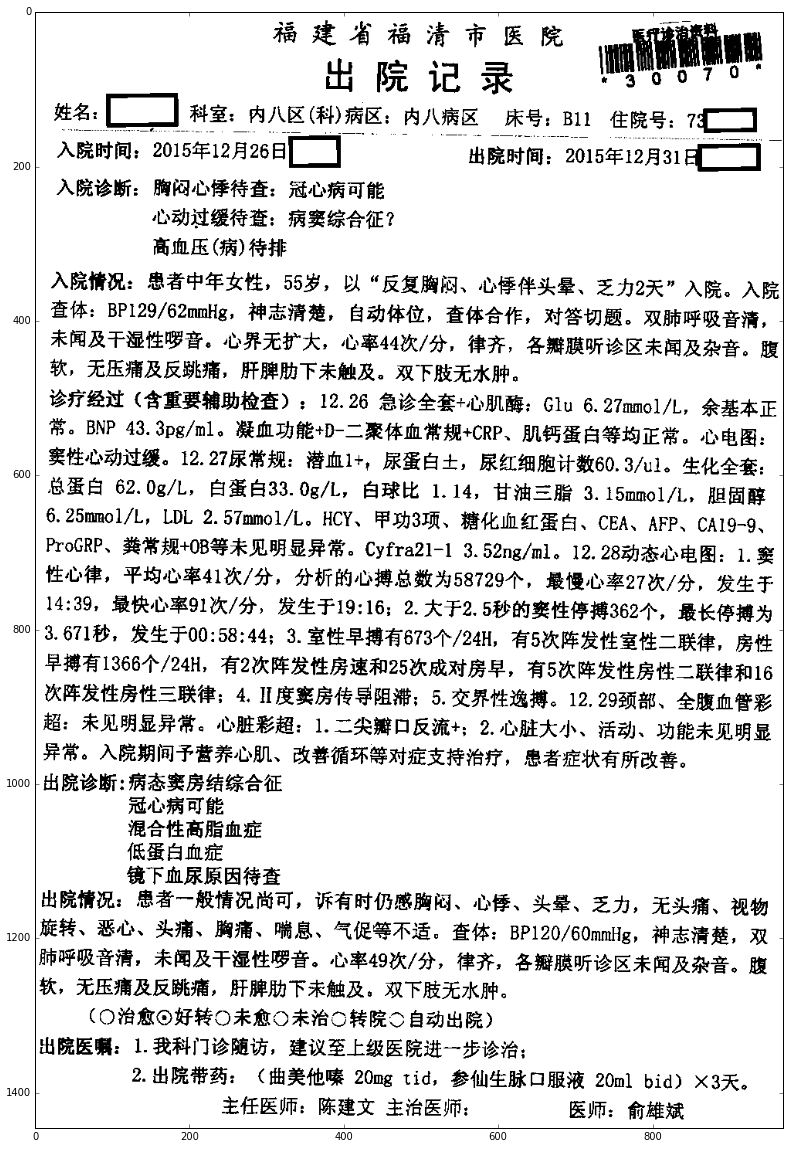

In [46]:
plt.imshow(cv2.threshold(warped, 200, 255, cv2.THRESH_BINARY)[1], cmap='gray')

(1446, 970)
(1546, 1070)
[[ 47 212]
 [ 46 163]
 [993 154]
 [994 204]]


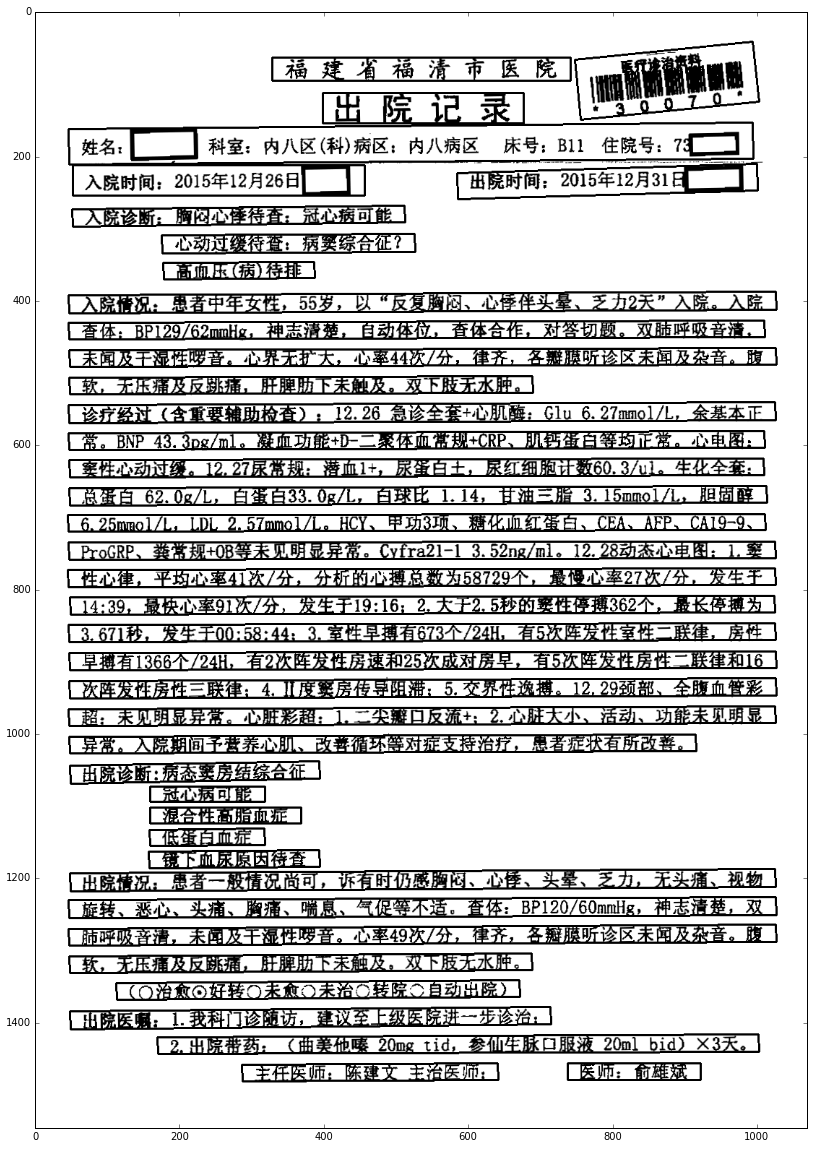

In [43]:
gray_boxed, cnts, boxes = find_bounding_box(warped, (20, 1), 2, threshold=200, padding=1)
matplotlib.rcParams['figure.figsize'] = (40.0, 20.0) 
plt.imshow(255 - gray_boxed, cmap='gray')


cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
rect = cv2.minAreaRect(cnts_sorted[0]) # get the largest bounding box
box = np.int0(cv2.boxPoints(rect))
print(box)

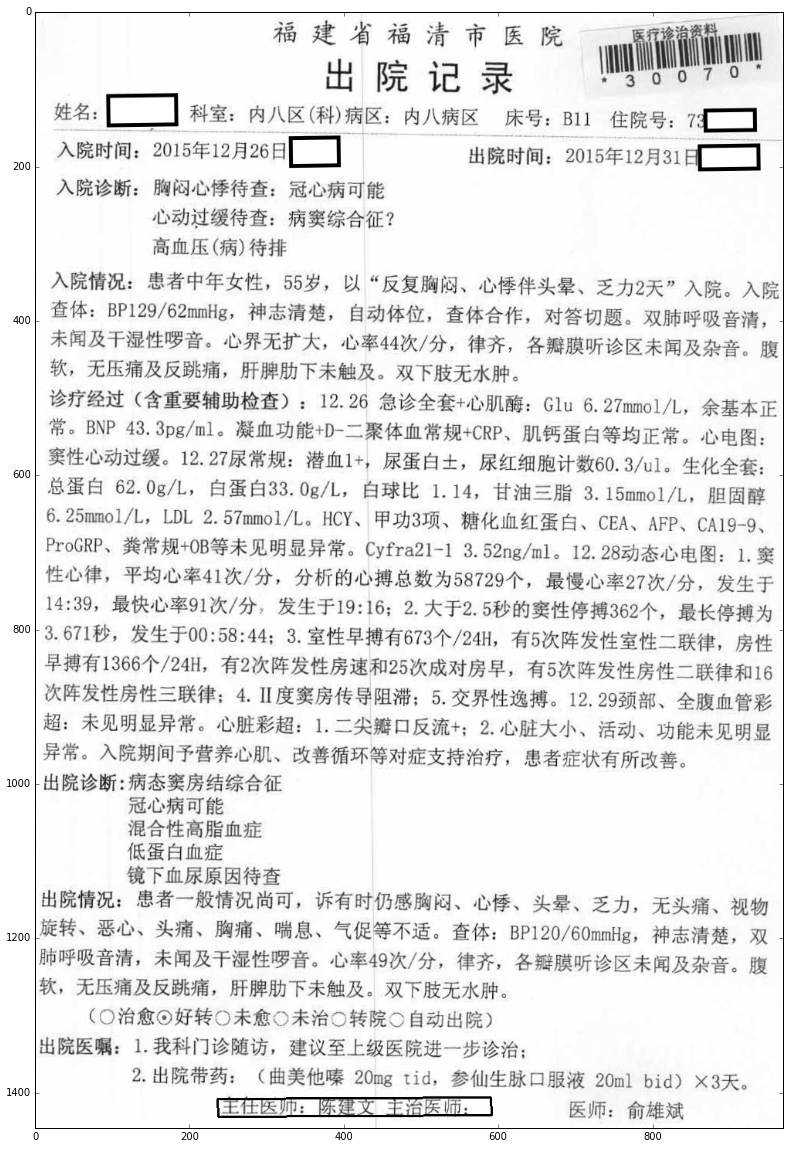

In [42]:
rect = cv2.minAreaRect(cnts[0]) # get the largest bounding box
box = np.int0(cv2.boxPoints(rect))

outlined = warped.copy()
cv2.drawContours(outlined, [box], -1, 0, 2)

plt.imshow(outlined, cmap='gray')

In [36]:
len(cnts)

40

In [ ]:
image = find_bounding_box(padded)
plt.imshow(255-image, cmap='gray')